# Notebook to analyse leviation position data
written by Jan on June 5th
 
This is the master version of the notebook, this should always be the latest version!

## Assumptions (required files)
This notebook assumes the following:
1. a video (**`video_file_name` = video.avi**) has been recoded and its metainformation has been extracted with metainfo (www.MediaArea.net)
    - into a json file with the same name and location (exept for the ending) as the original video file (**source_folder_video/video.json**). 
    - Typically the video and .json files are located in a video folder, which we will call **source_folder_video**
2. video data has been extracted using the **`extract_position_data`** function in track_sphere with one particular *method*
    - the extracted data is in a .cvs file and resides in a folder, which we call **source_folder_positions** 
    - the name of the .csv is the same as the original video file except that the *method* used to extract the postion data has been added to the name (**source_folder_positions/video-method.dat**)
    - in addition to the .csv file the is a .json file with the most relevant metadata of the video and all the parameters used in extracting the metadata (**source_folder_positions/video-method.json**)
3. the package `track_sphere` is available and located at **track_sphere_path** (can be set to None if included in the `PYTHON_PATH`)
    
## Main output from this notebook (outdated)
This notebook processes position data from a video of levitated magnet motion and produces the following files:
- images with spectra,  saved to **image_folder/video_file_name**

## Instructions on how to use this notebook (outdated)

This notebook analyses a video that measures a ring down experiment. 
For a new video:
    1. make a copy of this notebook
    2. rename the copy to reflect the name of the video that will be analyized (i.e. replace master in the ipynb name with the name of the video file)
    3. scroll down to settings and update
    4. execute cells
    (the first time you might want to active reencoding and extract position (section 1 and 2) and then deactivate it for future analyism ie only work with section after section 2)
    
Each section can be run independently. So to do one part of the analysis just go to the corresponding section
    


#### define the folders

In [46]:
source_folder_video = '../example_data/'
source_folder_positions = '../position_data/'
# track_sphere_path = '/Users/rettentulla/PycharmProjects/track_sphere/'
track_sphere_path = '../'
image_folder = '../images/'

#### define the name of the video file

In [ ]:
video_file_name = '20171207_magnet.avi'

#### load packages

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt

import scipy.optimize as sopt
import scipy.spatial
import scipy.ndimage

from collections import Counter
import glob
from scipy.signal import find_peaks_cwt

import yaml, json
pix_to_um = 0.651 # conversion factor pixel to um
%matplotlib inline

# auto reload external files, so that we can edit the external .py file and inmediately see the changes here
%load_ext autoreload
%autoreload 2

# font settings for plots
font = {
    'size': 16
}
matplotlib.rc('lines', linewidth = 2)
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = [9, 6]

if track_sphere_path is not None:
    os.sys.path.append(track_sphere_path)
from track_sphere import plot_data as pltd
from track_sphere import utils as ts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### set some varibales

In [50]:
os.path.join(image_folder, video_file_name[:-4])

'../images/20171207_magnet'

### load data and file info 

In [64]:
data, info = ts.load_time_trace(source_folder_positions, video_file_name, methods=['Bright px', 'fit_ellipse', 'fit_blobs'], verbose=True)

Bright px skipped frames: 0
fit_ellipse skipped frames: 0
fit_blobs skipped frames: 0
data set contains:  Index(['bright px x', 'bright px y', 'contour center x', 'contour center y',
       'ellipse a', 'ellipse angle', 'ellipse b', 'ellipse x', 'ellipse y',
       'b0 a', 'b0 angle', 'b0 b', 'b0 thresh', 'b0 x', 'b0 y', 'b1 a',
       'b1 angle', 'b1 b', 'b1 thresh', 'b1 x', 'b1 y', 'b2 a', 'b2 angle',
       'b2 b', 'b2 thresh', 'b2 x', 'b2 y', 'b3 a', 'b3 angle', 'b3 b',
       'b3 thresh', 'b3 x', 'b3 y', 'b4 a', 'b4 angle', 'b4 b', 'b4 thresh',
       'b4 x', 'b4 y'],
      dtype='object')
data shape is:  (10001, 39)


In [63]:
info['info']

{'BitDepth': 8,
 'CodecID': 'MJPG',
 'Duration': 10.251,
 'FileSize': 50305910,
 'FrameCount': 10001,
 'FrameRate': 975.609,
 'Height': 200,
 'Width': 200}

0.0010250007943756155

# Time traces

### looking at different features

In [88]:
min_frame, max_frame = 0,100
features = ['ellipse', 'b0', 'b1', 'b2', 'b3', 'b4']

Text(0.5,0,'time (ms)')

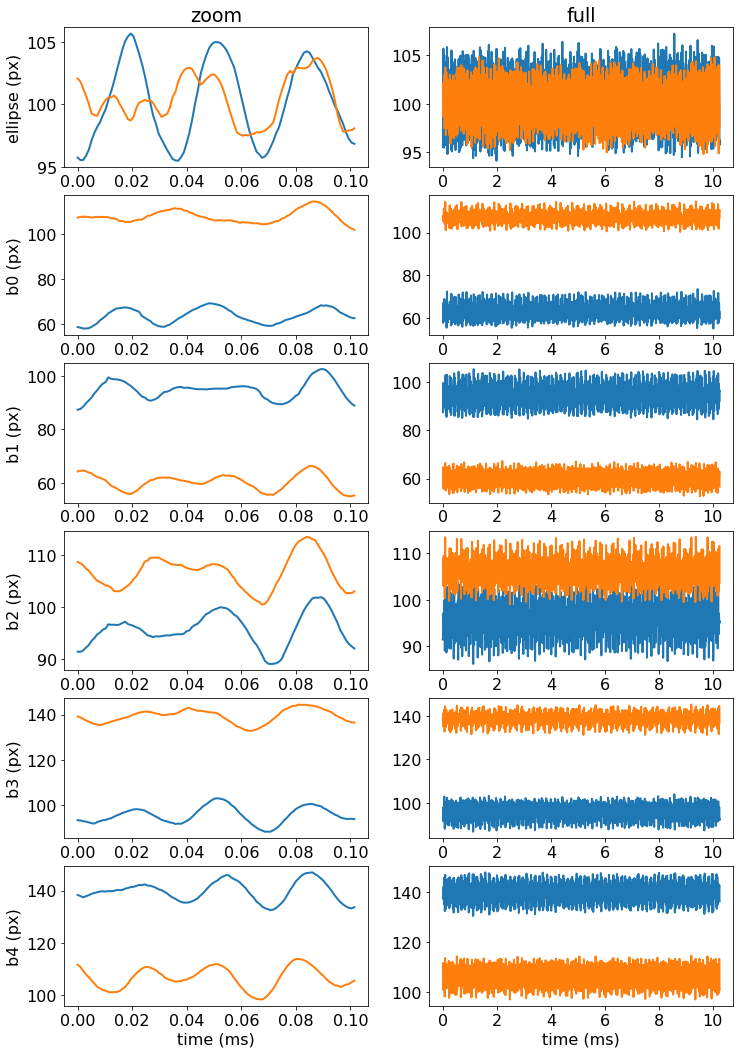

In [100]:
dt = 1./info['info']['FrameRate']
frames = np.arange(min_frame, max_frame)
f, axes = plt.subplots(len(features), 2, sharey=False, sharex=False,figsize = (12,3*len(features)))
t = dt * frames
t2 = dt * np.arange(len(data))
for i, (feature, (ax1, ax2)) in enumerate(zip(features, axes)):
    
    ax1.plot(t, data[feature + ' x'][frames])
    ax1.plot(t, data[feature + ' y'][frames])
    ax2.plot(t2, data[feature + ' x'])
    ax2.plot(t2, data[feature + ' y'])

    ax1.set_ylabel(feature + ' (px)')
    if i == 0:
        ax1.set_title('zoom')
        ax2.set_title('full')
        
    
ax1.set_xlabel('time (ms)')
ax2.set_xlabel('time (ms)')
# ax2.set_ylabel('amplitude (px)')

### looking at ellipse features

In [107]:
min_frame, max_frame = 0,100
coordinates = ['x', 'y', 'a', 'b', 'angle']
feature = 'ellipse'

Text(0.5,0,'time (s)')

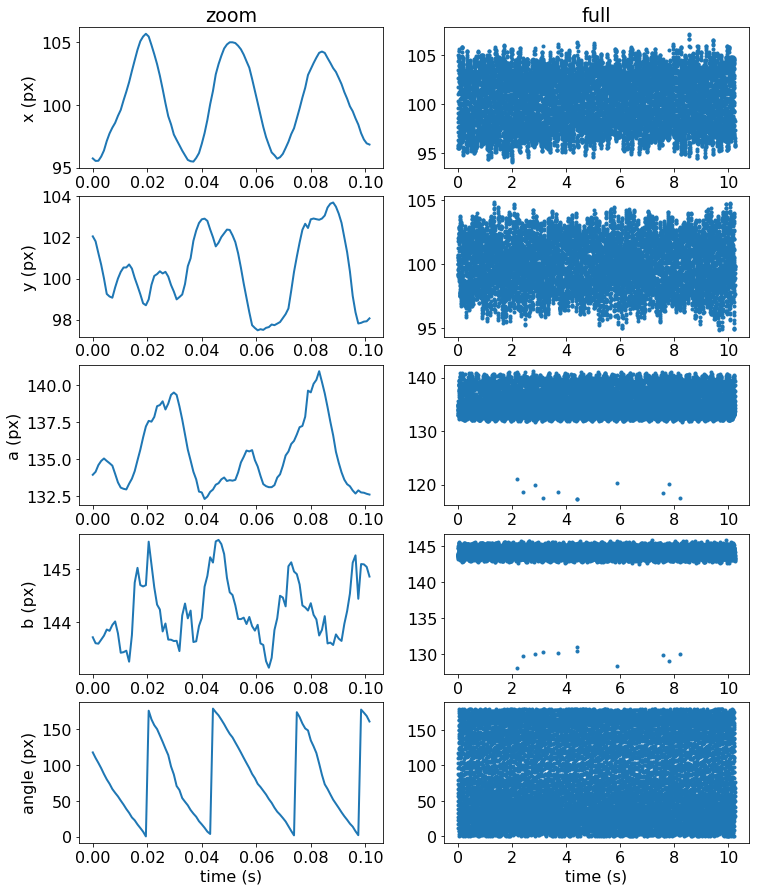

In [157]:
dt = 1./info['info']['FrameRate']
frames = np.arange(min_frame, max_frame)
f, axes = plt.subplots(len(coordinates), 2, sharey=False, sharex=False,figsize = (12,3*len(coordinates)))
t = dt * frames
t2 = dt * np.arange(len(data))
for i, (c, (ax1, ax2)) in enumerate(zip(coordinates, axes)):
    
    ax1.plot(t, data[feature + ' ' + c][frames])
    ax2.plot(t2, data[feature + ' ' + c], '.')

    ax1.set_ylabel(c + ' (px)')
    if i == 0:
        ax1.set_title('zoom')
        ax2.set_title('full')
        
    
ax1.set_xlabel('time (s)')
ax2.set_xlabel('time (s)')
# ax2.set_ylabel('amplitude (px)')

### the rotational angle is special, so we treat it seperately

rotational freq: -17.85 Hz


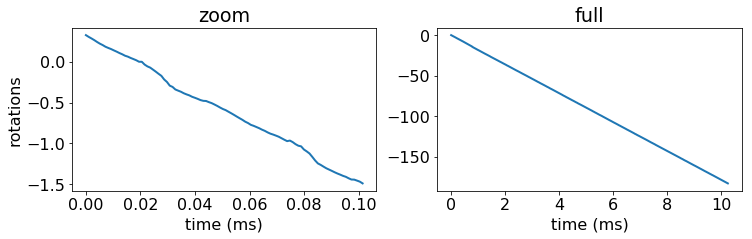

In [164]:
rot_angle = np.unwrap(data[feature + ' angle'], discont=100)
dt = 1./info['info']['FrameRate']
frames = np.arange(min_frame, max_frame)
f, axes = plt.subplots(1, 2, sharey=False, sharex=False,figsize = (12,3))
t = dt * frames
t2 = dt * np.arange(len(data))
ax1, ax2 = axes
ax1.plot(t, rot_angle[frames]/360)
ax2.plot(t2, rot_angle/360)


ax1.set_title('zoom')
ax2.set_title('full')

ax1.set_ylabel('rotations')
    
ax1.set_xlabel('time (ms)')
ax2.set_xlabel('time (ms)')

print('rotational freq: {:0.2f} Hz'.format(np.mean(np.diff(rot_angle)/(360*dt))))

### checking the area

rotational freq: -17.85 Hz


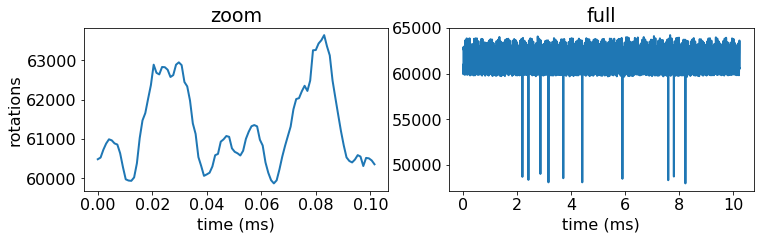

In [168]:
area = data[feature + ' a']*data[feature + ' b']*np.pi
dt = 1./info['info']['FrameRate']
frames = np.arange(min_frame, max_frame)
f, axes = plt.subplots(1, 2, sharey=False, sharex=False,figsize = (12,3))
t = dt * frames
t2 = dt * np.arange(len(data))
ax1, ax2 = axes
ax1.plot(t, area[frames])
ax2.plot(t2, area)


ax1.set_title('zoom')
ax2.set_title('full')

ax1.set_ylabel('rotations')
    
ax1.set_xlabel('time (ms)')
ax2.set_xlabel('time (ms)')

print('rotational freq: {:0.2f} Hz'.format(np.mean(np.diff(rot_angle)/(360*dt))))

## 5) Look at power spectral densities (PSD)

In [96]:
min_freq, max_freq = 10,100

Text(0.5,0,'time (ms)')

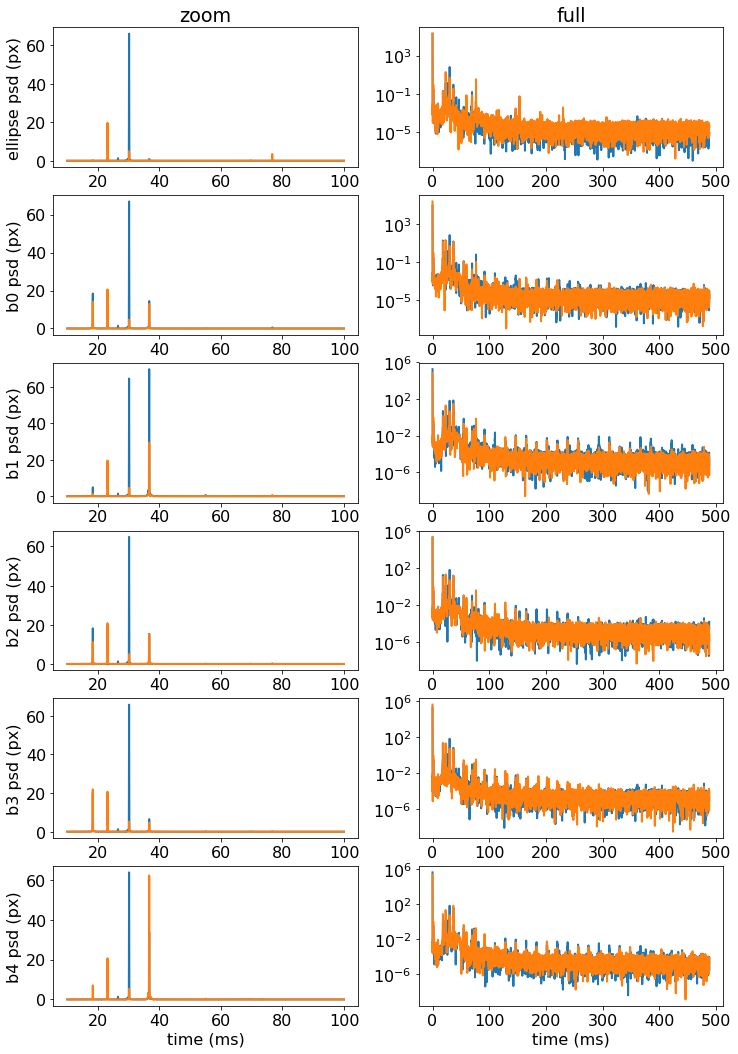

In [105]:
time_step = 1./info['info']['FrameRate']
frames = np.arange(min_frame, max_frame)
f, axes = plt.subplots(len(features), 2, sharey=False, sharex=False,figsize = (12,3*len(features)))
t = dt * frames
t2 = dt * np.arange(len(data))
for i, (feature, (ax1, ax2)) in enumerate(zip(features, axes)):
    for x in ['x', 'y']:
        f, p = ts.power_spectral_density(data[feature + ' ' + x], time_step, frequency_range = None)
        ax2.semilogy(f, p)
        f, p = ts.power_spectral_density(data[feature + ' ' + x], time_step, frequency_range = (min_freq, max_freq))
        ax1.plot(f, p)
    
    ax1.set_ylabel(feature + ' psd (px)')
    if i == 0:
        ax1.set_title('zoom')
        ax2.set_title('full')
        
    
ax1.set_xlabel('frequency (Hz)')
ax2.set_xlabel('frequency (Hz)')
# ax2.set_ylabel('amplitude (px)')

### looking at ellipse features

Text(0.5,0,'frequency (Hz)')

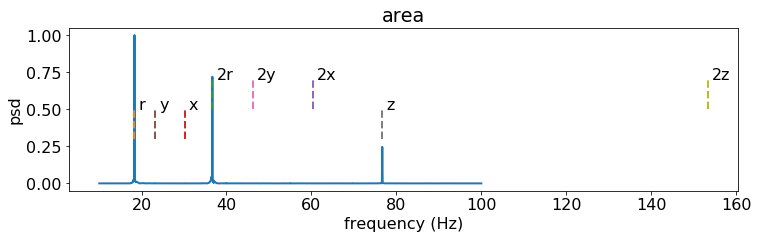

In [237]:
def annotate_frequencies(ax, annotation_dict, y_offset, higher_harm = 1):
    
    if len(np.shape([y_offset])) == 1:
        y_offset = np.ones(len(annotation_dict))*y_offset
        alternate_y = True
    else:
        alternate_y = False
    
    for offset, (k, v) in zip(y_offset, annotation_dict.items()):
        for hh in range(higher_harm):
            
            if hh == 0:
                text = k
                x = v
                y = offset
            else:
                text = '2'+ k
                x = 2*v 
                y = offset + 0.2
            
#             if alternate_y and 
            
            ax1.plot([x, x], [y-0.2, y], '--')
            ax1.annotate(text, xy=(x, y), xytext=(x+1, y),
                arrowprops=None,
                )



area = data[feature + ' a']*data[feature + ' b']*np.pi

rot_angle = np.unwrap(data[feature + ' angle'], discont=100)

dt = 1./info['info']['FrameRate']
f, ax1 = plt.subplots(1, 1, sharey=False, sharex=False,figsize = (12,3))

f, p = ts.power_spectral_density(area, time_step, frequency_range = (min_freq, max_freq))
ax1.plot(f, p/max(p))


# offset = np.ones(len(annotation_dict))*2e6
# offset[-2]+=0.5e6
# offset[-3]-=0.5e6
annotate_frequencies(ax1, annotation_dict, y_offset=0.5, higher_harm=2)



ax1.set_title('area')

ax1.set_ylabel('psd')
    
ax1.set_xlabel('frequency (Hz)')

In [234]:
annotation_dict = modes
# annotation_dict['2x a'] = 2*modes['a']
annotation_dict = {
    'r': 18.339615238476156,
#     'angle': 36.679230476952313,
#     'b': 36.679230476952313,
    'x': 30.143303769623042,
    'y': 23.119621337866217,
    'z': 76.675199880012016
}


In [220]:
c

'angle'

76.675199880012016

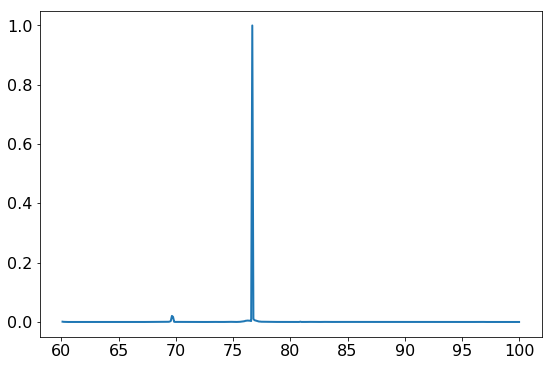

In [221]:
f, p = ts.power_spectral_density(data[feature + ' ' + 'y'], time_step, frequency_range = (60, max_freq))
plt.plot(f, p/max(p))
f[np.argmax(p)]

In [222]:
min_freq, max_freq = 10,100
coordinates = ['x', 'y', 'a', 'b', 'angle']
feature = 'ellipse'

Text(0.5,0,'time (s)')

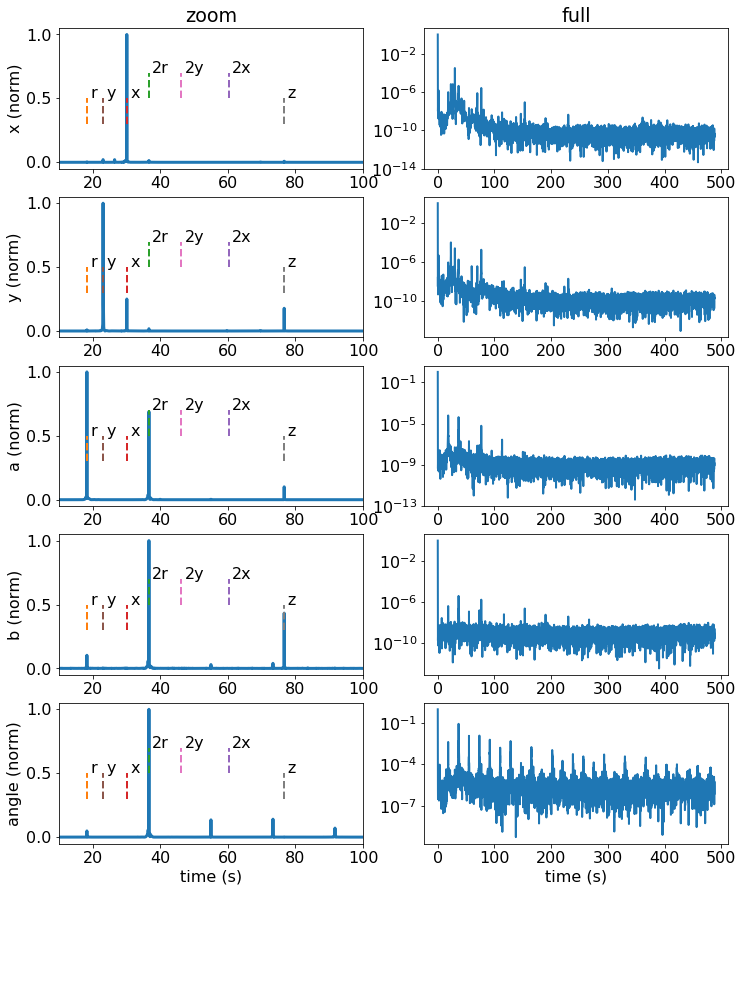

In [238]:
dt = 1./info['info']['FrameRate']
frames = np.arange(min_frame, max_frame)
f, axes = plt.subplots(len(coordinates), 2, sharey=False, sharex=False,figsize = (12,3*len(coordinates)))
t = dt * frames
t2 = dt * np.arange(len(data))

modes = {}
for i, (c, (ax1, ax2)) in enumerate(zip(coordinates, axes)):
    f, p = ts.power_spectral_density(data[feature + ' ' + c], time_step, frequency_range = None)
    ax2.semilogy(f, p/max(p))
    f, p = ts.power_spectral_density(data[feature + ' ' + c], time_step, frequency_range = (min_freq, max_freq))
    ax1.plot(f, p/max(p), linewidth=3)
    
#     if i == 0:
    annotate_frequencies(ax1, annotation_dict, 0.5, higher_harm=2)
    
    modes[c] = f[np.argmax(p)]

    ax1.set_ylabel(c + ' (norm)')
    if i == 0:
        ax1.set_title('zoom')
        ax2.set_title('full')
    ax1.set_xlim((min_freq, max_freq))
        
    
ax1.set_xlabel('time (s)')
ax2.set_xlabel('time (s)')
# ax2.set_ylabel('amplitude (px)')

Text(0.5,0,'frequency (Hz)')

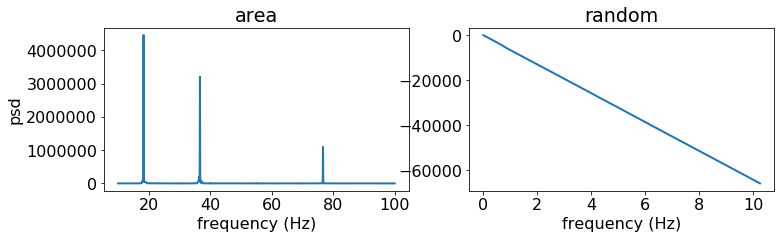

In [172]:
area = data[feature + ' a']*data[feature + ' b']*np.pi

rot_angle = np.unwrap(data[feature + ' angle'], discont=100)

dt = 1./info['info']['FrameRate']
f, axes = plt.subplots(1, 2, sharey=False, sharex=False,figsize = (12,3))
ax1, ax2 = axes

f, p = ts.power_spectral_density(area, time_step, frequency_range = (min_freq, max_freq))
ax1.plot(f, p)
f, p = ts.power_spectral_density(rot_angle, time_step, frequency_range = (min_freq, max_freq))
ax2.plot(t2, rot_angle)


ax1.set_title('area')
ax2.set_title('random')

ax1.set_ylabel('psd')
    
ax1.set_xlabel('frequency (Hz)')
ax2.set_xlabel('frequency (Hz)')

In [95]:
mode_freq, mode_width = 140, 20
mode_f_min, mode_f_max = mode_freq-mode_width/2, mode_freq+mode_width/2

#### load info

In [96]:
with open(filename_info, 'r') as infile:
    info = yaml.safe_load(infile)
info

{'N_frames': 2207079,
 'duration': 3678.465,
 'end_time': '2018-05-22 17:35:12',
 'filename_raw': 'C:\\Users\\Experiment\\Desktop\\tmp_data\\trapping_11_4\\ringdown_z_2_4_reencode.avi',
 'filename_xy_position': 'C:\\Users\\Experiment\\Desktop\\tmp_data\\processed\\trapping_11_4\\ringdown_z_2_4_reencode_data_globalmax.csv',
 'folder_path_processed': 'C:\\Users\\Experiment\\Desktop\\tmp_data\\processed\\trapping_11_4\\',
 'frame_rate': 600.0,
 'gaussian_filter_width': 2,
 'image_size': [144, 144],
 'info': 'This video is part of the golden dataset',
 'max_frames': 100000.0,
 'start_time': '2018-05-22 17:32:39',
 'tags': ['golden dataset'],
 'trackpy_parameters': {'diameter': 11, 'minmass': None, 'missing_frames': []},
 'use_trackpy': False}

#### plot the psd as a function of time as a 2D plot

In [100]:
time_step = 1./info['frame_rate']

total number of frames:		100002
total number of windows:	33


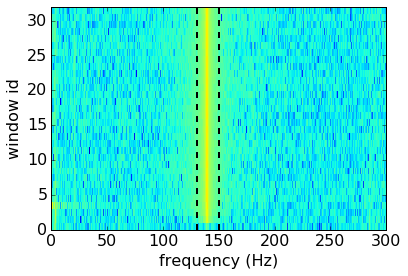

In [134]:
# start_frame = 100000
start_frame = 0 # starting frame for analysis
window_length = 3000 # length of window over which we compute the psd
end_frame = None # end frame for analysis (optional if None end_frame is len of total timetrace)
channel = 0 # channel 0=x, 1=y

# start script
cd_plot.plot_psd_vs_time(xy[:,channel],time_step=time_step,
                         start_frame = start_frame, window_length= window_length, end_frame = end_frame,
                         full_spectrum = True, 
                         frequency_range = [mode_f_min, mode_f_max])


In [137]:
range(40,50)

[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

total number of frames:		100002
total number of windows:	100


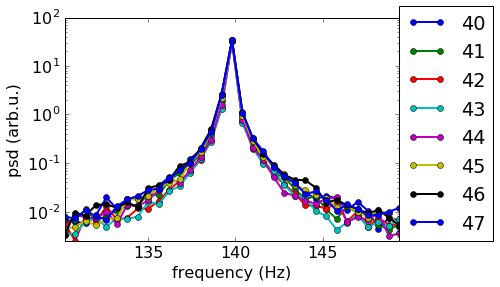

In [149]:
# start script
cd_plot.plot_psds(xy[:,channel],time_step=time_step,window_ids=range(40,48),
                         start_frame = start_frame, window_length= window_length, end_frame = end_frame,
                         full_spectrum = False, 
                         frequency_range = [mode_f_min, mode_f_max])

total number of frames:		100002
total number of windows:	100


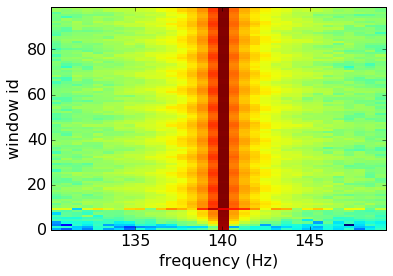

In [135]:
# start_frame = 100000
start_frame = 0 # starting frame for analysis
window_length = 1000 # length of window over which we compute the psd
end_frame = None # end frame for analysis (optional if None end_frame is len of total timetrace)
channel = 0 # channel 0=x, 1=y

# start script
cd_plot.plot_psd_vs_time(xy[:,channel],time_step=time_step,
                         start_frame = start_frame, window_length= window_length, end_frame = end_frame,
                         full_spectrum = False, 
                         frequency_range = [mode_f_min, mode_f_max])


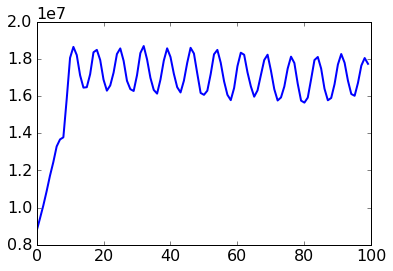

In [136]:
f_of_t, a_of_t = cd.get_freq_and_amp_timetrace(xy[:,channel], frequency_range = [mode_f_min, mode_f_max],
                              dt = time_step,nbin=window_length, velocity_type=True)
plt.plot(a_of_t)

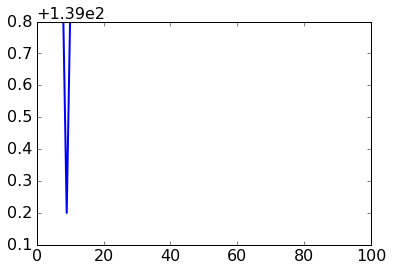

In [130]:
plt.plot(f_of_t)

# looking at the individual frames and playing around with the data

In [9]:
filename_raw = 'Z:\\Lab\\Lev\\videos\\20180322_LevSample_6\\20180529_Sample_6_bead_1\\20180529_Sample6_bead_1_direct_thermal_01.avi'

frames =[0, 1, 1000, 5000]

roi = [[63, 53], [15, 15]]

images = cd.get_frames(file_path=filename_raw, frames=frames, gaussian_filter_width=2, roi = roi)

In [10]:
np.shape(images)

(4L, 15L, 15L)

C:\ProgramData\Anaconda2\lib\site-packages\scipy\ndimage\measurements.py:1301: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


[nan, nan]
[-3.123860363907988, 32.2033142406121]
[9.977107934510666, 0.6872520812431031]
[14.084516593614262, -31.815405819447996]


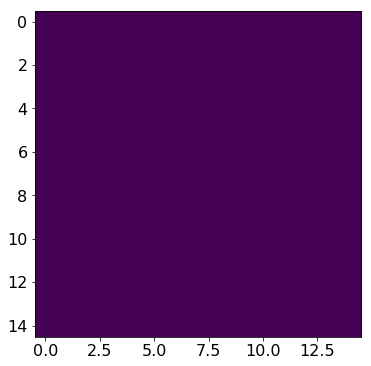

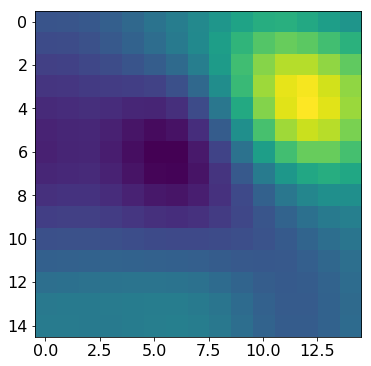

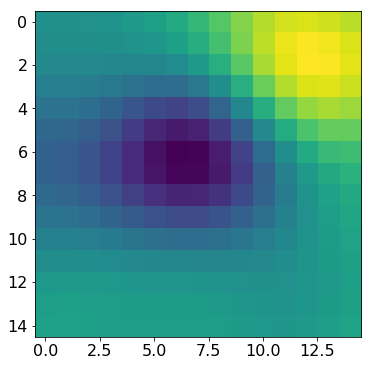

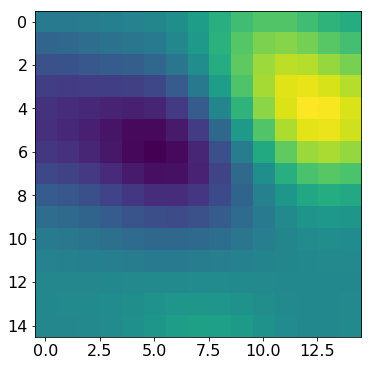

In [12]:
for image in images:
    plt.figure()
    img = image-images[0]
    plt.imshow(img)
    print(cd.get_center_of_mass(img))

# Using OpenCV - not finished

In [53]:
filename_raw = 'Z:\\Lab\\Lev\\videos\\20180322_LevSample_6\\20180529_Sample_6_bead_1\\20180529_Sample6_bead_1_direct_thermal_01_reencode_short.avi'

In [ ]:

import numpy as np
import cv2
cap = cv2.VideoCapture(filename_raw)
fgbg = cv2.createBackgroundSubtractorMOG2()
while(1):
    ret, frame = cap.read()
    fgmask = fgbg.apply(frame)
    cv2.imshow('frame',fgmask)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
cap.release()
cv2.destroyAllWindows()

# Playing around with Trackpy to get the position


In [28]:
import trackpy as tp

#### plot the first frame and the region of interest
The size of the circle shows the expected size of the spot

In [3]:
filename_raw = 'Z:\\Lab\\Lev\\videos\\20180322_LevSample_6\\20180529_Sample_6_bead_1\\20180529_Sample6_bead_1_direct_thermal_01.avi'
roi= [[60, 52], [31, 31]]

trackpy_parameters ={'diameter': 11, 'minmass': 3}

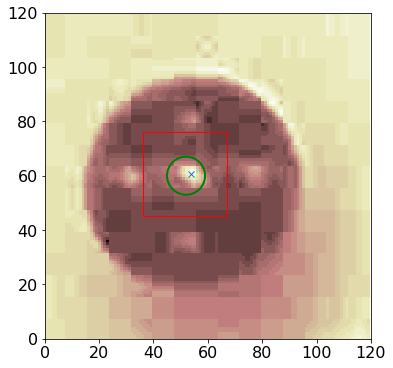

In [34]:
fig, ax = cd_plot.plot_video_frame(filename_raw, [0], xy_position = np.array([roi[0]]), gaussian_filter_width=None, xylim = None, roi = roi, ax = None, radius = (trackpy_parameters['diameter'])/2)

trackpy_parameters = {
    'diameter':15,
    'minmass': 2
}

locate_info = tp.locate(image, trackpy_parameters['diameter'], minmass=trackpy_parameters['minmass'])

ax[0].plot(locate_info['x'], locate_info['y'], 'x')

In [35]:
locate_info

,x,y,mass,size,ecc,signal,raw_mass,ep
0,53.874899,60.527323,2.831224,3.744289,0.17587,0.058534,16.152941,-1.284838


In [39]:
image_n

array([[185, 185, 185, ..., 208, 208, 197],
       [185, 185, 185, ..., 208, 208, 197],
       [185, 185, 185, ..., 208, 197, 197],
       ...,
       [185, 185, 185, ..., 208, 208, 208],
       [185, 185, 185, ..., 208, 208, 208],
       [185, 185, 185, ..., 208, 208, 208]])

In [44]:
image_i = plt.np.invert(image_n)

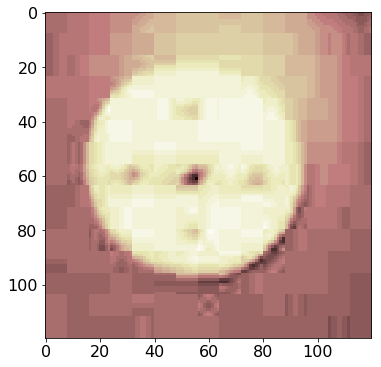

In [45]:
plt.imshow(image_i, cmap='pink')

In [15]:
filename_raw
import pims
from pims import pipeline
from skimage.color import rgb2gray
rgb2gray_pipeline = pipeline(rgb2gray)

In [33]:
?pims.Video

Init signature: pims.Video(self, filename, **kwargs)
Docstring:      <no docstring>
File:           c:\programdata\anaconda2\lib\site-packages\pims\imageio_reader.py
Type:           ABCMeta


In [8]:
v = pims.Video(filename_raw)

In [31]:
x = v[0]

In [34]:
np.sum(np.array(x[:,:,0])-np.array(x[:,:,2]))

0

In [18]:
video = pipeline(v)

AttributeError: 'ImageIOReader' object has no attribute '__name__'

In [17]:
video[0]

array([[0.13333333, 0.13333333, 0.13333333, ..., 0.14117647, 0.14117647,
        0.1372549 ],
       [0.13333333, 0.13333333, 0.13333333, ..., 0.14117647, 0.14117647,
        0.1372549 ],
       [0.13333333, 0.13333333, 0.13333333, ..., 0.14117647, 0.1372549 ,
        0.1372549 ],
       ...,
       [0.13333333, 0.13333333, 0.13333333, ..., 0.14117647, 0.14117647,
        0.14117647],
       [0.13333333, 0.13333333, 0.13333333, ..., 0.14117647, 0.14117647,
        0.14117647],
       [0.13333333, 0.13333333, 0.13333333, ..., 0.14117647, 0.14117647,
        0.14117647]])

In [52]:
trackpy_parameters = {
    'diameter':11,
    'minmass': 1
}

locate_info = tp.locate(image, trackpy_parameters['diameter'], minmass=trackpy_parameters['minmass'])
locate_info

,x,y,mass,size,ecc,signal,raw_mass,ep
0,53.945659,60.716090,2.001705,3.030325,0.143738,0.054175,9.635294,1.264426
1,84.297470,87.418432,1.032720,3.253975,0.337779,0.026556,10.588235,0.384526
2,58.988948,99.857851,1.114938,3.206261,0.252844,0.024432,11.117647,0.277314


In [40]:
def normalize_to_byte(image):
    return (255*(image - np.min(image))/np.ptp(image)).astype(np.dtype('B'))

In [5]:
image = cd.get_frames(filename_raw, 0, gaussian_filter_width=None, roi = None)[0]

In [41]:
image_n =  normalize_to_byte(image)

,x,y,mass,size,ecc,signal,raw_mass,ep
0,53.874899,60.527323,2.831224,3.744289,0.17587,0.058534,16.152941,-1.284838


In [6]:
cd.get_position_trackpy(image_n, roi[0], trackpy_parameters=trackpy_parameters, verbose=True)

C:\ProgramData\Anaconda2\lib\site-packages\trackpy\feature.py:617: UserWarning: No maxima survived mass- and size-based prefiltering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0. See the documentation and the convenience function minmass_version_change.
  warnings.warn("No maxima survived mass- and size-based prefiltering. "


Empty DataFrame
Columns: [x, y, mass, size, ecc, signal, raw_mass, ep]
Index: []


In [27]:
trackpy_parameters = {
    'diameter':15,
    'minmass': 2
}

cd.get_position_trackpy(image_n, roi[0], trackpy_parameters=trackpy_parameters, verbose=True)

            x           y         mass      size       ecc     signal  \
0   59.966440   13.527104  1063.480582  4.351237  0.291292  14.354175   
1   52.137033   36.184933  2326.541339  3.395583  0.237034  54.063669   
2   12.557913   41.263432  4513.690151  4.430343  0.215418  61.887840   
3   94.433564   73.171972  4337.644791  4.350822  0.351226  67.319049   
4  110.446190   75.309216   499.294420  3.661851  0.207327  14.493086   
5   20.835104   85.931005  3986.914644  4.392865  0.197482  56.273630   
6   58.160406  100.377013  5847.203210  4.316282  0.302704  79.778688   

   raw_mass        ep  
0   12551.0  0.181856  
1    7810.0  0.527532  
2   24356.0  0.069105  
3   23602.0  0.071954  
4   27397.0  0.059588  
5   26089.0  0.063340  
6   26954.0  0.060807  


array([52.13703349, 36.18493339])

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(np.min(image), np.max(image)))
scaler = scaler.fit(image)
X_scaled = scaler.transform(image)

X_scaled


array([[0.09934641, 0.09934641, 0.09934641, ..., 0.15686275, 0.15686275,
        0.12810458],
       [0.09934641, 0.09934641, 0.09934641, ..., 0.15686275, 0.15686275,
        0.12810458],
       [0.09934641, 0.09934641, 0.09934641, ..., 0.15686275, 0.12810458,
        0.12810458],
       ...,
       [0.09934641, 0.09934641, 0.09934641, ..., 0.15686275, 0.15686275,
        0.15686275],
       [0.09934641, 0.09934641, 0.09934641, ..., 0.15686275, 0.15686275,
        0.15686275],
       [0.09934641, 0.09934641, 0.09934641, ..., 0.15686275, 0.15686275,
        0.15686275]])

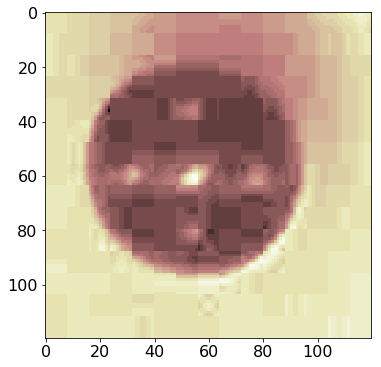

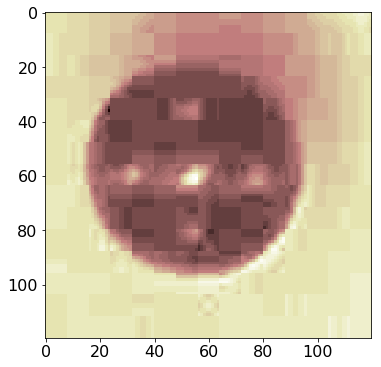

In [11]:
plt.imshow(image, cmap='pink')

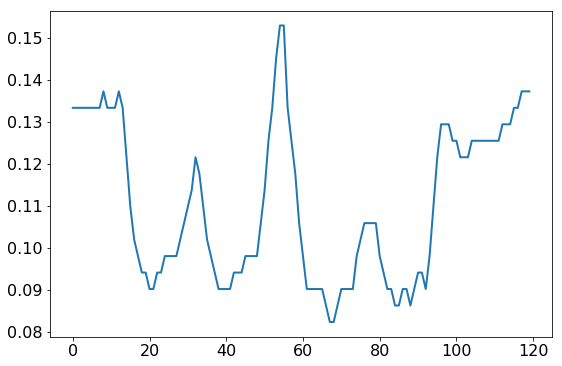

In [26]:
plt.plot(image[60])

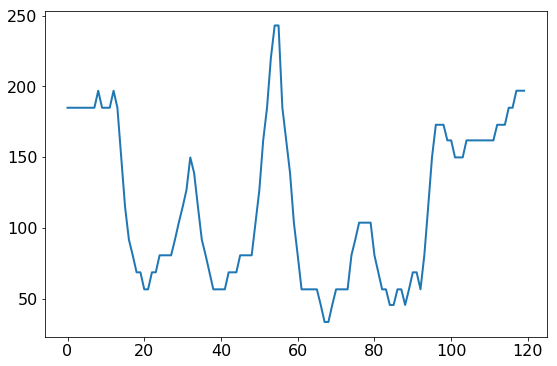

In [25]:
plt.plot(image_n[60])

In [24]:
np.min(image_n), np.max(image_n)

(0, 255)

In [35]:
import cv2 as cv

In [36]:
cv.__version__

'3.4.0'